In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from privacy_leakage.LTM import LTM
from privacy_leakage.DT import DT
import pickle

def perturb_distribution_new(CMF, l):
    
    n = np.shape(CMF)[0]
    CMF_list_upper = []
    CMF_list_lower = []
    diff_list = []
    for i in range(n):
        G = CMF[i,:]
        for j in range(n):
            if i == j:
                continue
            CMF_noisy = []
            noisy_row_1 = []
            noisy_row_2 = []
            G_prime = CMF[j,:]
            for k in range(n):
                if G[k]/G_prime[k] > 1:
                    noisy_row_1.append(min(G[k] + G[k] * l,1))
                    noisy_row_2.append(max(0, G_prime[k] - G[k] * l))
                else:
                    noisy_row_1.append(max(G[k] - G[k] * l,0))
                    noisy_row_2.append(min(1, G_prime[k] + G[k] * l))
            noisy_row_1 = np.array(noisy_row_1)
            noisy_row_2 = np.array(noisy_row_2)
            CMF_noisy.append(noisy_row_1/np.sum(noisy_row_1))
            CMF_noisy.append(noisy_row_2/np.sum(noisy_row_2))
            diff_list.append(np.max(np.abs(CMF_noisy[0]- G)/G))
            diff_list.append(np.max(np.abs(CMF_noisy[1]- G_prime)/G_prime))
            CMF_list_upper.append(np.array(CMF_noisy))

            CMF_noisy = []
            noisy_row_1 = []
            noisy_row_2 = []
            for k in range(n):
                if G[k]/G_prime[k] < 1:
                    noisy_row_1.append(G[k] + min( G[k] * l, abs(G[k]-G_prime[k])/2))
                    noisy_row_2.append(G_prime[k] - min( G_prime[k] * l, abs(G[k]-G_prime[k])/2))
                else:
                    noisy_row_1.append(G[k] - min( G[k] * l, abs(G[k]-G_prime[k])/2))
                    noisy_row_2.append(G_prime[k] + min( G_prime[k] * l, abs(G[k]-G_prime[k])/2))
            noisy_row_1 = np.array(noisy_row_1)
            noisy_row_2 = np.array(noisy_row_2)
            CMF_noisy.append(noisy_row_1/np.sum(noisy_row_1))
            CMF_noisy.append(noisy_row_2/np.sum(noisy_row_2))
            diff_list.append(np.max(np.abs(CMF_noisy[0]- G)/G))
            diff_list.append(np.max(np.abs(CMF_noisy[1]- G_prime)/G_prime))
            CMF_list_lower.append(np.array(CMF_noisy))
    return CMF_list_upper, CMF_list_lower, max(diff_list)



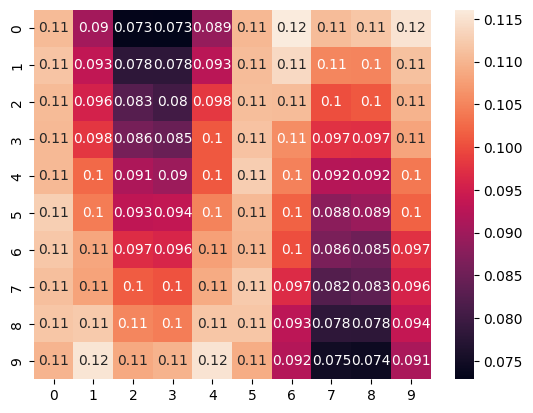

In [2]:
eps_list = [0.1, 0.5, 1, 2,  3,  4,  5, 6, 7, 8, 9, 10]

leakage_actual_known = []
leakage_DB = []
leakage_DB_without_delta = []
leakage_actual = []

with open(f'synthetic_datasets/synthetic_CMF_{10}.pkl', 'rb') as file:
    CMF = pickle.load(file)

sns.heatmap(CMF, annot=True)
plt.show()
CMF_list_upper, CMF_list_lower, max_error = perturb_distribution_new(CMF, 0.032)

for eps in eps_list:
    leakage_actual_upper_inner = []
    leakage_actual_lower_inner = []
    max_error_list = []

    for index_i, _ in enumerate(CMF_list_lower):
        leakage_actual_upper_inner.append(LTM(eps=eps, CMF=CMF_list_upper[index_i])) #Algo1_updated_privacy_leakage(eps, i)[0])
        leakage_actual_lower_inner.append(LTM(eps=eps, CMF=CMF_list_lower[index_i]))
        max_error_list.append(max_error)
    Delta = max(max_error_list)

    min_ = np.nanmax(np.array(leakage_actual_lower_inner))
    max_ = np.nanmax(np.array(leakage_actual_upper_inner))
    leakage_actual.append([min_, max_])
    leakage_DB.append(DT(eps = eps, CMF = CMF, Delta = CMF*Delta))
    leakage_DB_without_delta.append(DT(eps = eps, CMF = CMF, Delta = 0))
    leakage_actual_known.append(LTM(eps, CMF)[0])


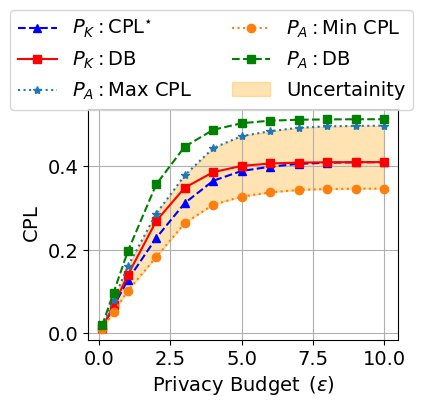

In [3]:


plt.figure(figsize=(4, 3))

leakage_actual_arr = np.array(leakage_actual)


plt.plot(eps_list, leakage_actual_known, '--^b')
plt.plot(eps_list, leakage_DB_without_delta, '-sr')
plt.plot(eps_list, leakage_actual_arr[:,1], ':*')
plt.plot(eps_list, leakage_actual_arr[:,0], ':o')
plt.plot(eps_list, leakage_DB, '--sg')

plt.fill_between(eps_list, leakage_actual_arr[:,0], leakage_actual_arr[:,1], where=(leakage_actual_arr[:,1] >= leakage_actual_arr[:,0]), interpolate=True, color='orange', alpha=0.3)
plt.xlabel(r"$\operatorname{Privacy \text{ } Budget}$ $(\epsilon)$", fontsize=14)
plt.ylabel(r"$\operatorname{CPL}$", fontsize=14)
plt.tick_params(axis='x', labelsize=14) 
plt.tick_params(axis='y', labelsize=14)
plt.legend([ r"$P_K:\operatorname{CPL}^\star$", r"$P_K:\operatorname{DB}$", r"$P_A:\text{Max CPL}$", r"$P_A:\text{Min CPL}$", r"$P_A:\operatorname{DB}$", "Uncertainity"], fontsize=14, bbox_to_anchor=(1.08, 1.47), ncol=2)
ax = plt.grid(True)


In [4]:
eps_list = [0.1, 0.5, 1, 2,  3,  4,  5, 6, 7, 8, 9, 10]
delta_list = [0, 0.05, 0.10, 0.2, 0.5]

leakage_DB = []

with open(f'synthetic_datasets/synthetic_CMF_{10}.pkl', 'rb') as file:
    CMF = pickle.load(file)

for delta in delta_list:
    inner_leakage_DB = []
    for eps in eps_list:
        inner_leakage_DB.append(DT(eps = eps, CMF = CMF, Delta = CMF * delta))
    leakage_DB.append(inner_leakage_DB)


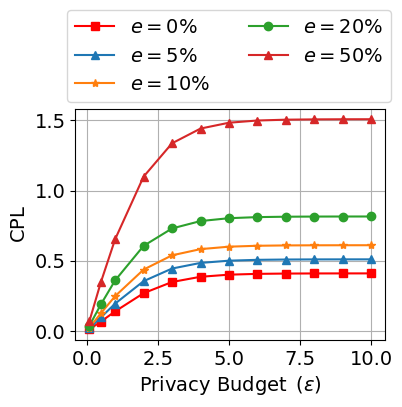

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
plt.plot(eps_list, leakage_DB[0], '-sr')
plt.plot(eps_list, leakage_DB[1], '-^')
plt.plot(eps_list, leakage_DB[2], '-*')
plt.plot(eps_list, leakage_DB[3], '-o')
plt.plot(eps_list, leakage_DB[4], '-^')

plt.xlabel(r"$\operatorname{Privacy \text{ } Budget}$ $(\epsilon)$", fontsize=14)
plt.ylabel(r"$\text{CPL}$", fontsize=14)
plt.tick_params(axis='x', labelsize=14)  # Font size for x-axis numbers
plt.tick_params(axis='y', labelsize=14)  # Font size for y-axis numbers

legend_list = []
for delta in delta_list:
    legend_list.append(r"$e=$"+f"{int(delta*100)}%")

plt.legend(legend_list, fontsize=14, bbox_to_anchor=(1.05, 1.47), ncol=2)
ax = plt.grid(True)
